#### Analysis of Battery Profits

Notebook investigating the days when batteries were most profitable, and if there is a relation between these days and the overall fuel production in the NEM, based on fuel sources

1. Performed EDA
    * Region wide trends
    * Intraday analysis
2. Created following features
    * indicator for 90% quantile of battery profits (target variable)
    * fuel type generation percentage w.r.t all fuel type generations
    * one hot encoding for region id
    * cyclic encoding of month variable
3. Fitted a logistic regression model, found most important predictors were wind generation, region id and month
4. Evaluated and extended analysis

In [354]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df = pd.read_parquet('aaa_dispatch_list')
print(df.shape)
df.head()

(38400624, 8)


,SETTLEMENTDATE,DUID,INITIALMW,TOTALCLEARED,AVAILABILITY,Fuel Source - Primary,REGIONID,RRP
0,2025-01-01 00:05:00,ADPBA1,1.217,2.0,6.0,Battery Storage,SA1,141.4772
1,2025-01-01 00:05:00,ADPPV1,0.000,0.0,0.0,Solar,SA1,141.4772
2,2025-01-01 00:05:00,AGLHAL,0.000,0.0,196.0,Fossil,SA1,141.4772
3,2025-01-01 00:05:00,AGLSOM,0.000,0.0,160.0,Fossil,VIC1,130.0000
4,2025-01-01 00:05:00,ANGAST1,0.000,0.0,44.0,Fossil,SA1,141.4772


In [355]:
df_batt = df.query("`Fuel Source - Primary` == 'Battery Storage'").copy()
df_batt['date'] = df_batt['SETTLEMENTDATE'].dt.date
df_batt['month'] = df_batt['SETTLEMENTDATE'].dt.month
df_batt.head()

,SETTLEMENTDATE,DUID,INITIALMW,TOTALCLEARED,AVAILABILITY,Fuel Source - Primary,REGIONID,RRP,date,month
0,2025-01-01 00:05:00,ADPBA1,1.2170,2.0,6.0,Battery Storage,SA1,141.4772,2025-01-01,1
7,2025-01-01 00:05:00,BALB1,0.0000,0.0,30.0,Battery Storage,VIC1,130.0000,2025-01-01,1
23,2025-01-01 00:05:00,BHB1,-0.1133,0.0,0.0,Battery Storage,NSW1,138.0279,2025-01-01,1
27,2025-01-01 00:05:00,BLYTHB1,-0.5600,0.0,0.0,Battery Storage,SA1,141.4772,2025-01-01,1
34,2025-01-01 00:05:00,BOWWBA1,-0.0420,0.0,2.0,Battery Storage,SA1,141.4772,2025-01-01,1


In [356]:
df_batt['profit'] = df_batt['TOTALCLEARED'] * df_batt['RRP'] / 12
df_prof = df_batt.groupby(['date', 'DUID', 'REGIONID', 'month'])['profit'].sum().reset_index()

# removing december as insufficient data for this month
df_prof = df_prof[df_prof['month'] != 12]
df_prof.head()

,date,DUID,REGIONID,month,profit
0,2025-01-01,ADPBA1,SA1,1,2942.620649
1,2025-01-01,BALB1,VIC1,1,6041.923202
2,2025-01-01,BHB1,NSW1,1,3966.808487
3,2025-01-01,BLYTHB1,SA1,1,0.000000
4,2025-01-01,BOWWBA1,SA1,1,991.552568


Base data frame obtained, now looking at a few trends for batteries

In [357]:
# How has profit changed for a specific battery over the year
    # looking at profits region wide can be misleading as new batteries entered the market

jan_batt = list(df_prof.query("month == 1")['DUID'].unique())
print(jan_batt)

['ADPBA1', 'BALB1', 'BHB1', 'BLYTHB1', 'BOWWBA1', 'BULBES1', 'CAPBES1', 'CBWWBA1', 'CHBESS1', 'DALNTH1', 'DPNTB1', 'GANNB1', 'GREENB1', 'HBESS1', 'HPR1', 'HVWWBA1', 'KEPBG1', 'KEPBL1', 'LBB1', 'PIBESS1', 'QBYNB1', 'RANGEB1', 'RESS1', 'RIVNB2', 'TB2B1', 'TIB1', 'VBB1', 'WALGRV1', 'WANDB1', 'WDBESS1', 'WTAHB1', 'KESSB1']


Quick overview of the yearly trend in battery profit

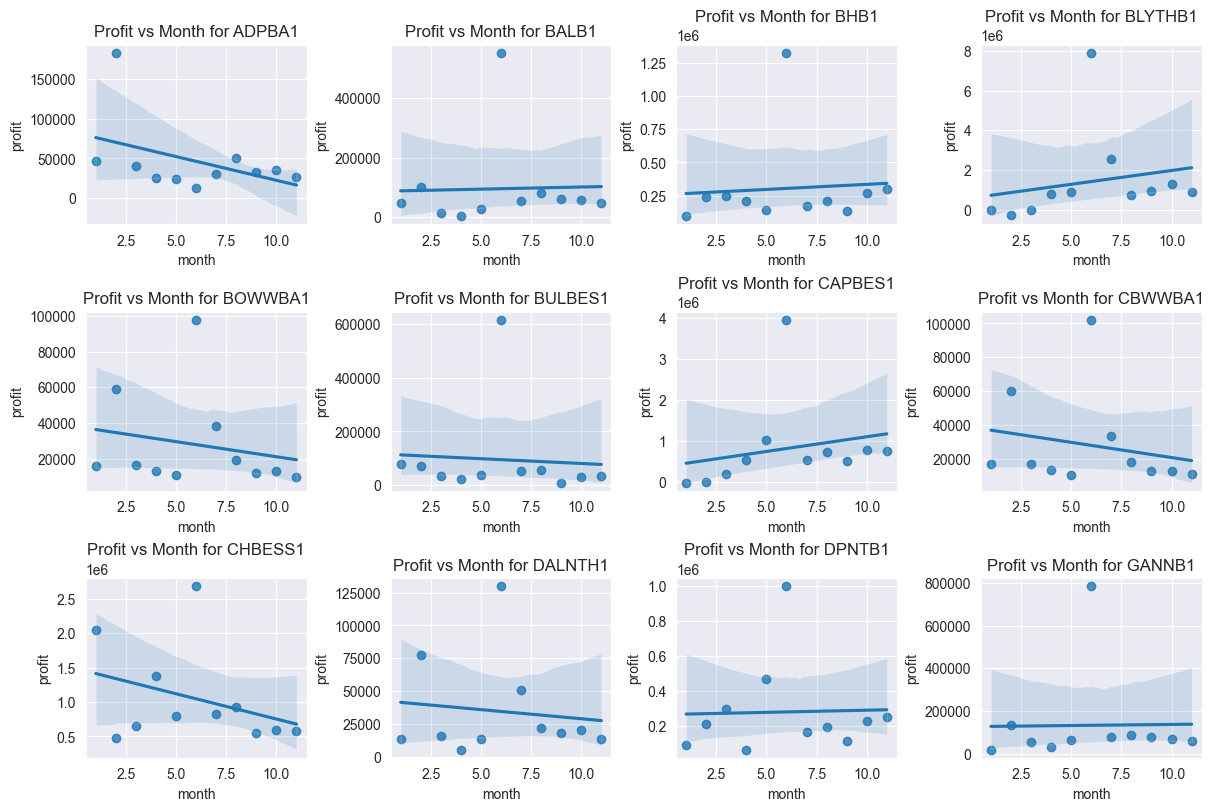

In [358]:
rows = 3
cols = 4
fig, axs = plt.subplots(rows, cols, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()

for i, duid in enumerate(jan_batt[:rows*cols]):
    df_duid = df_prof.query("DUID == @duid").groupby('month')['profit'].sum().reset_index()
    sns.regplot(data = df_duid, x = 'month', y = 'profit', ax = axs[i])
    axs[i].set_title(f'Profit vs Month for {duid}')


At a glance, hard to tell overall trend, looking at region wide basis now

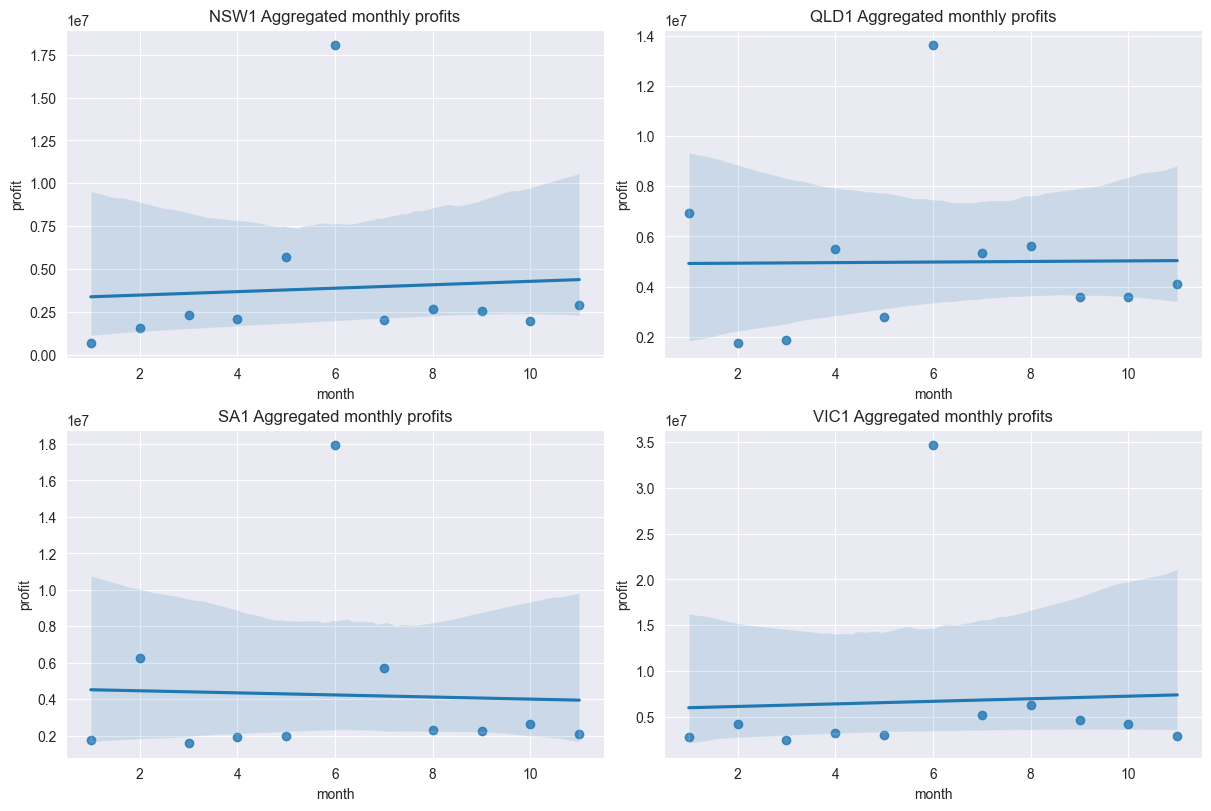

In [359]:
df_reg = df_prof[df_prof['DUID'].isin(jan_batt)]
df_reg = df_reg.groupby(['REGIONID', 'month'])['profit'].sum().reset_index()

reg = list(df_reg['REGIONID'].unique())
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()

for i, region in enumerate(reg):
    data =  df_reg.query("REGIONID == @region")
    sns.regplot(data =data, x = 'month', y = 'profit', ax = axs[i])
    axs[i].set_title(f'{region} Aggregated monthly profits')

Sideways, though slight upward trend. Major outlier is what happened in June. Analysing the plots without June below to see the effect of the outlier.

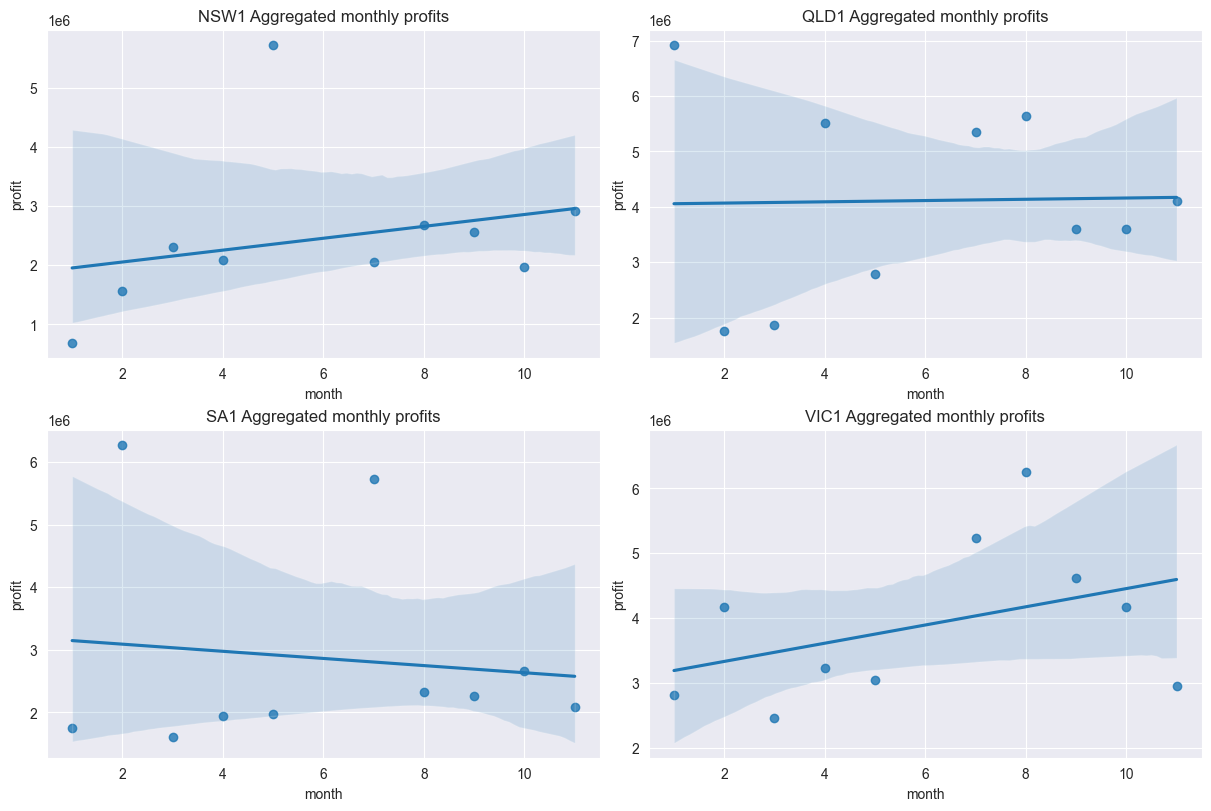

In [360]:
df_reg = df_prof[(df_prof['DUID'].isin(jan_batt)) & (df_prof['month'] != 6)]
df_reg = df_reg.groupby(['REGIONID', 'month'])['profit'].sum().reset_index()

reg = list(df_reg['REGIONID'].unique())
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)
axs = axs.flatten()

for i, region in enumerate(reg):
    data =  df_reg.query("REGIONID == @region")
    sns.regplot(data =data, x = 'month', y = 'profit', ax = axs[i])
    axs[i].set_title(f'{region} Aggregated monthly profits')

Overall, the profits of batteries seems to be increasing across the NEM, despite the market becoming increasingly competitive, and peak prices decreasing.

#### Intraday Analysis

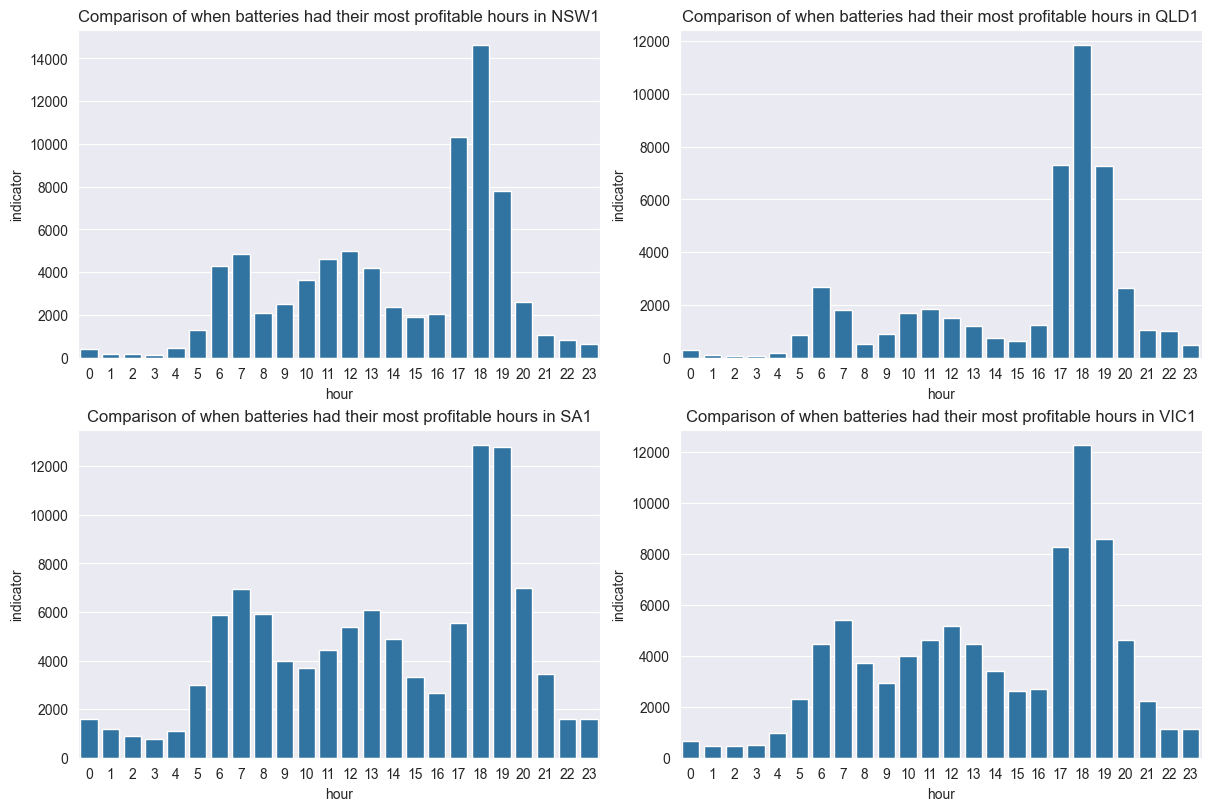

In [361]:
df_batt['hour'] = df_batt['SETTLEMENTDATE'].dt.hour
prof_q = df_batt.groupby(['DUID'])['profit'].agg(
    q90 =  lambda x: x.quantile(0.9)
)

df_res = df_batt.join(prof_q, on = 'DUID', how = 'inner')
df_res['indicator'] = (df_res['profit'] > df_res['q90']).astype(int)
df_res['indicator'].describe()

df_hour = df_res.groupby(['hour', 'REGIONID'])['indicator'].sum().reset_index()

fig, axs = plt.subplots(2,2, figsize = (12, 8), constrained_layout = True)
axs = axs.flatten()

for i, reg in enumerate(['NSW1', 'QLD1', 'SA1', 'VIC1']):
    sns.barplot(data = df_hour[df_hour['REGIONID'] == reg], x = 'hour', y = 'indicator', ax = axs[i])
    axs[i].set_title(f'Comparison of when batteries had their most profitable hours in {reg}')

Evening peak is consistently the time of day when high profit events are most likely to occur. 

#### Investigating the specific days batteries made the most money

creating an indicator for when each batteries had their most profitable days region wide (> 90% quantile)

In [362]:
df_prof = df_prof[df_prof['DUID'].isin(jan_batt)]
df_date = df_prof.groupby(['date', 'REGIONID'])['profit'].sum().reset_index()
df_thresh = df_date.groupby(['REGIONID'])['profit'].agg(
    q90 = lambda x: x.quantile(0.9))
df_date = df_date.merge(df_thresh, on = 'REGIONID', how = 'left')
df_date['prof_indicator'] = (df_date['profit'] > df_date['q90']).astype(int)
print(df_date.groupby('prof_indicator').size())
df_date

prof_indicator
0    1200
1     136
dtype: int64


,date,REGIONID,profit,q90,prof_indicator
0,2025-01-01,NSW1,24188.043383,155566.733920,0
1,2025-01-01,QLD1,194150.215774,216458.997528,0
2,2025-01-01,SA1,122497.336425,133753.609862,0
3,2025-01-01,VIC1,178454.380115,223710.361242,0
4,2025-01-02,NSW1,-5630.280207,155566.733920,0
...,...,...,...,...,...
1331,2025-11-29,VIC1,122611.376655,223710.361242,0
1332,2025-11-30,NSW1,39714.296840,155566.733920,0
1333,2025-11-30,QLD1,81800.416030,216458.997528,0
1334,2025-11-30,SA1,71290.454200,133753.609862,0


Merging back to the original data frame, so can compare the generation of other fuel sources. Doing data manipulation first to get data frame in desired shape

In [363]:
df['date'] = df['SETTLEMENTDATE'].dt.date
print(df[df['TOTALCLEARED'] < 0]['Fuel Source - Primary'].unique())

['Battery Storage']


Retaining only batteries that existed in January, to focus on high profit days as a result of other weather conditions, rather than just an increase of batteries in the NEM

In [364]:
df1 = df[df['Fuel Source - Primary'] == 'Battery Storage']
df2 = df[df['Fuel Source - Primary'] != 'Battery Storage']
df1 = df1[df1['DUID'].isin(jan_batt)]
df = pd.concat([df1, df2])
df['Fuel Source - Primary'].unique()

array(['Battery Storage', 'Solar', 'Fossil', 'Wind', 'Hydro', '-'],
      dtype=object)

In [365]:
mask_batt = df['Fuel Source - Primary'] == 'Battery Storage'

df['Fuel Source - Primary'] = np.where(
    mask_batt & (df['TOTALCLEARED'] < 0),
    'Battery Load',
    df['Fuel Source - Primary']
)

print(df['Fuel Source - Primary'].unique())

['Battery Storage' 'Battery Load' 'Solar' 'Fossil' 'Wind' 'Hydro' '-']


In [366]:
df['TOTALCLEARED'] = df['TOTALCLEARED'] / 12
df['profit'] = df['TOTALCLEARED'] * df['RRP']

df_day = df.groupby(['date', 'Fuel Source - Primary', 'REGIONID']).agg(
    totalcleared=('TOTALCLEARED', 'sum'),
    profit=('profit', 'sum')
).reset_index()

df_day.head()

,date,Fuel Source - Primary,REGIONID,totalcleared,profit
0,2025-01-01,-,NSW1,786.266969,-17214.290273
1,2025-01-01,-,QLD1,3473.388889,-47128.047979
2,2025-01-01,Battery Load,NSW1,-462.582873,-2320.229662
3,2025-01-01,Battery Load,QLD1,-623.415702,-2007.329191
4,2025-01-01,Battery Load,SA1,-604.626218,107011.239071


In [367]:
df_pivot1 = df_day.pivot(index = ['date', 'REGIONID'], columns = 'Fuel Source - Primary', values = 'totalcleared').reset_index()
df_pivot1.head()

Fuel Source - Primary,date,REGIONID,-,Battery Load,Battery Storage,Fossil,Hydro,Solar,Wind
0,2025-01-01,NSW1,786.266969,-462.582873,215.826965,114866.914332,7372.751682,35208.071844,14642.213155
1,2025-01-01,QLD1,3473.388889,-623.415702,484.505942,118729.019235,4097.679979,13523.887396,6644.675446
2,2025-01-01,SA1,NaN,-604.626218,209.328613,2728.491570,NaN,1212.611186,14874.982187
3,2025-01-01,TAS1,NaN,NaN,NaN,0.000000,9483.686892,NaN,5243.371458
4,2025-01-01,VIC1,NaN,-979.330864,507.707613,69360.202591,3036.428170,3347.816177,18178.083247


In [368]:
df_cleared_merge = df_pivot1.merge(df_date, on = ['date', 'REGIONID'], how = 'left')
df_cleared_merge.head()

,date,REGIONID,-,Battery Load,Battery Storage,Fossil,Hydro,Solar,Wind,profit,q90,prof_indicator
0,2025-01-01,NSW1,786.266969,-462.582873,215.826965,114866.914332,7372.751682,35208.071844,14642.213155,24188.043383,155566.733920,0.0
1,2025-01-01,QLD1,3473.388889,-623.415702,484.505942,118729.019235,4097.679979,13523.887396,6644.675446,194150.215774,216458.997528,0.0
2,2025-01-01,SA1,NaN,-604.626218,209.328613,2728.491570,NaN,1212.611186,14874.982187,122497.336425,133753.609862,0.0
3,2025-01-01,TAS1,NaN,NaN,NaN,0.000000,9483.686892,NaN,5243.371458,NaN,NaN,NaN
4,2025-01-01,VIC1,NaN,-979.330864,507.707613,69360.202591,3036.428170,3347.816177,18178.083247,178454.380115,223710.361242,0.0


Noticed Tas had NAN, this is because there is no batteries in tasmania. Will drop REGIONID=Tas columns, also replace all NaN with 0's, as just means that fuel type didn't produce any fuel on that day

In [369]:

df_merge = df_cleared_merge[df_cleared_merge['REGIONID'] != 'TAS1'].fillna(0)
df_merge = df_merge.drop('-', axis = 1)

print(df_cleared_merge['REGIONID'].unique())
df_merge.head(5)

['NSW1' 'QLD1' 'SA1' 'TAS1' 'VIC1']


,date,REGIONID,Battery Load,Battery Storage,Fossil,Hydro,Solar,Wind,profit,q90,prof_indicator
0,2025-01-01,NSW1,-462.582873,215.826965,114866.914332,7372.751682,35208.071844,14642.213155,24188.043383,155566.733920,0.0
1,2025-01-01,QLD1,-623.415702,484.505942,118729.019235,4097.679979,13523.887396,6644.675446,194150.215774,216458.997528,0.0
2,2025-01-01,SA1,-604.626218,209.328613,2728.491570,0.000000,1212.611186,14874.982187,122497.336425,133753.609862,0.0
4,2025-01-01,VIC1,-979.330864,507.707613,69360.202591,3036.428170,3347.816177,18178.083247,178454.380115,223710.361242,0.0
5,2025-01-02,NSW1,-460.752653,166.998187,107385.059288,1681.313930,31989.459087,28837.212973,-5630.280207,155566.733920,0.0


A quick look at the data with respect to the profit indicator. Overall trend seems to be on high priced days, non - battery fuel sources had reduced production

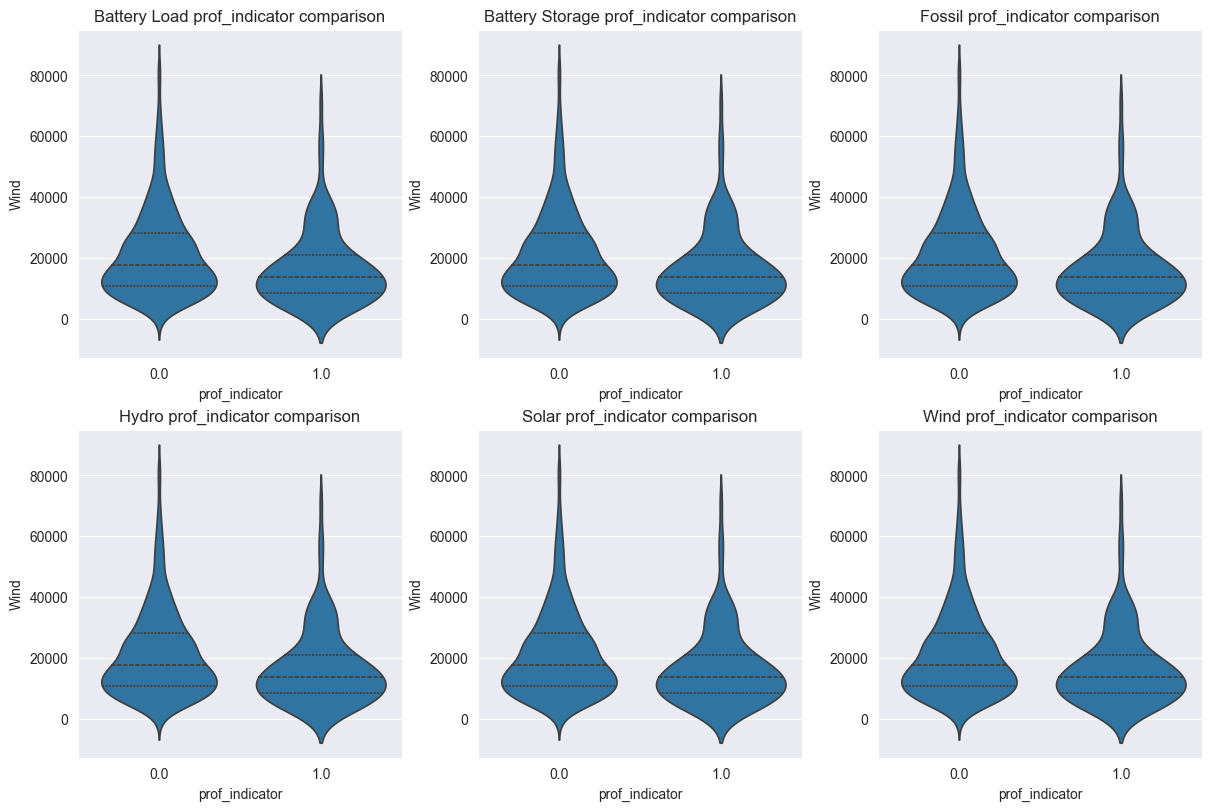

In [370]:
fig, axs = plt.subplots(2, 3, figsize = (12, 8), constrained_layout = True)
axs = axs.flatten()

for i, fuel in enumerate(['Battery Load', 'Battery Storage', 'Fossil', 'Hydro', 'Solar', 'Wind']):
    sns.violinplot(data = df_merge, x='prof_indicator', y = 'Wind', inner = 'quartile', ax = axs[i])
    axs[i].set_title(f'{fuel} prof_indicator comparison')

Want to predict when prof indicator will be 1. Doing data preperation making percentage based features

In [371]:
fuel_cols = ['Battery Storage', 'Fossil', 'Hydro', 'Solar', 'Wind']
total = df_merge[fuel_cols].sum(axis = 1)

share_cols = [f'{c}_share' for c in fuel_cols]
df_merge[share_cols] = df_merge[fuel_cols].div(total, axis=0)

df_merge.head(5)

,date,REGIONID,Battery Load,Battery Storage,Fossil,Hydro,Solar,Wind,profit,q90,prof_indicator,Battery Storage_share,Fossil_share,Hydro_share,Solar_share,Wind_share
0,2025-01-01,NSW1,-462.582873,215.826965,114866.914332,7372.751682,35208.071844,14642.213155,24188.043383,155566.733920,0.0,0.001253,0.666646,0.042789,0.204335,0.084978
1,2025-01-01,QLD1,-623.415702,484.505942,118729.019235,4097.679979,13523.887396,6644.675446,194150.215774,216458.997528,0.0,0.003377,0.827497,0.028559,0.094256,0.046311
2,2025-01-01,SA1,-604.626218,209.328613,2728.491570,0.000000,1212.611186,14874.982187,122497.336425,133753.609862,0.0,0.011003,0.143413,0.000000,0.063736,0.781848
4,2025-01-01,VIC1,-979.330864,507.707613,69360.202591,3036.428170,3347.816177,18178.083247,178454.380115,223710.361242,0.0,0.005377,0.734513,0.032155,0.035453,0.192503
5,2025-01-02,NSW1,-460.752653,166.998187,107385.059288,1681.313930,31989.459087,28837.212973,-5630.280207,155566.733920,0.0,0.000982,0.631454,0.009887,0.188107,0.169571


Quick look into if there is any key group changes between energy production on high and low priced days

In [372]:
df_merge.groupby('prof_indicator')[share_cols].mean()

,Battery Storage_share,Fossil_share,Hydro_share,Solar_share,Wind_share
prof_indicator,,,,,
0.0,0.008925,0.599073,0.030175,0.091040,0.270787
1.0,0.014523,0.668160,0.040150,0.089706,0.187461


In [373]:
df_merge.groupby('prof_indicator')[fuel_cols].mean()

,Battery Storage,Fossil,Hydro,Solar,Wind
prof_indicator,,,,,
0.0,718.705410,84352.115701,4581.901531,11813.524587,21313.292639
1.0,1272.760391,95943.316982,6515.833482,11674.121929,16654.761607


greatest difference seems to come from lost wind production, and the remaining outputs increasing. Seems reasonable as solar / wind will have lowest bid prices, reduced output leads to increased market prices

In [374]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

X_cols = ['Fossil_share', 'Hydro_share', 'Solar_share', 'Wind_share']
X = df_merge[X_cols]
y = df_merge['prof_indicator']

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])


pipe.fit(X, y)

,steps,"[('scaler', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0


Doing some model analysis of the predictive power

In [375]:
tscv = TimeSeriesSplit(n_splits=10)
auc = cross_val_score(pipe, X, y, cv=tscv, scoring='roc_auc')
print('CV ROC-AUC:', auc, 'Mean:', auc.mean())

CV ROC-AUC: [0.49565217 0.93277311 0.58960177 0.67657658 0.49325337 0.77
 0.60598897 0.63057851 0.50229358 0.40869565] Mean: 0.610541371320152


avg score of 0.664 is weak (baseline 0.5), though some predictive power exists)

In [376]:
coefs = pd.Series(pipe.named_steps['lr'].coef_[0], index=X_cols).sort_values()
print(coefs)

Wind_share     -1.918001
Fossil_share   -1.420187
Solar_share    -0.417665
Hydro_share     0.015459
dtype: float64


Increased wind share has the greatest effect on a high price event occuring, with increasing wind share decreasing the likelihood

In [377]:
X_cols = ['Fossil', 'Hydro', 'Solar', 'Wind']
X = df_merge[X_cols]
y = df_merge['prof_indicator']

pipe.fit(X, y)

tscv = TimeSeriesSplit(n_splits=10)
auc = cross_val_score(pipe, X, y, cv=tscv, scoring='roc_auc')
print('CV ROC-AUC:', auc, 'Mean:', auc.mean())
coefs = pd.Series(pipe.named_steps['lr'].coef_[0], index=X_cols).sort_values()
print(coefs)


CV ROC-AUC: [0.54492754 0.94537815 0.46460177 0.70810811 0.63943028 0.61666667
 0.61899133 0.6214876  0.60779817 0.60869565] Mean: 0.637608526941084
Wind     -0.387498
Solar    -0.332794
Fossil    0.126022
Hydro     0.376878
dtype: float64


Using the absolute energy production gives similar results, just high priced events are also correlated with increased hydro production. This is likely a result of missing wind production causing increased demand during the late afternoon peak

Adding month and region predictor variables

In [378]:
df = df_merge.copy()
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df.head()

,date,REGIONID,Battery Load,Battery Storage,Fossil,Hydro,Solar,Wind,profit,q90,prof_indicator,Battery Storage_share,Fossil_share,Hydro_share,Solar_share,Wind_share,month
0,2025-01-01,NSW1,-462.582873,215.826965,114866.914332,7372.751682,35208.071844,14642.213155,24188.043383,155566.733920,0.0,0.001253,0.666646,0.042789,0.204335,0.084978,1
1,2025-01-01,QLD1,-623.415702,484.505942,118729.019235,4097.679979,13523.887396,6644.675446,194150.215774,216458.997528,0.0,0.003377,0.827497,0.028559,0.094256,0.046311,1
2,2025-01-01,SA1,-604.626218,209.328613,2728.491570,0.000000,1212.611186,14874.982187,122497.336425,133753.609862,0.0,0.011003,0.143413,0.000000,0.063736,0.781848,1
4,2025-01-01,VIC1,-979.330864,507.707613,69360.202591,3036.428170,3347.816177,18178.083247,178454.380115,223710.361242,0.0,0.005377,0.734513,0.032155,0.035453,0.192503,1
5,2025-01-02,NSW1,-460.752653,166.998187,107385.059288,1681.313930,31989.459087,28837.212973,-5630.280207,155566.733920,0.0,0.000982,0.631454,0.009887,0.188107,0.169571,1


In [379]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import FunctionTransformer

X_cols = ['Fossil_share', 'Hydro_share', 'Solar_share', 'Wind_share', 'REGIONID', 'month']
#X_cols = ['Fossil', 'Hydro', 'Solar', 'Wind', 'REGIONID', 'month']
X = df[X_cols].copy()
X['month'] = X['month'].astype('int')
y = df['prof_indicator']

# using cyclic encoding for month
def month_sin_cos(m):
    m = np.asarray(m).astype(float)
    angle = 2 * np.pi * (m - 1) / 12.0
    return np.c_[np.sin(angle), np.cos(angle)]

month_transformer = Pipeline(steps=[
    ("cyclic", FunctionTransformer(month_sin_cos, validate=False))
])

numeric_pre = Pipeline([
    ('scaler', StandardScaler())
])

categorical_pre = Pipeline([
    ('ohe', OneHotEncoder())
])

preprocess = ColumnTransformer(
    transformers=[
        ('month', month_transformer, ['month']),
        ('num', numeric_pre, selector(dtype_include=np.number)),
        ('cat', categorical_pre, selector(dtype_include=object))
    ],
    remainder='drop'
)

pipe2 = Pipeline([
    ('preprocess', preprocess),
    ('lr', LogisticRegression())
    ]
)

pipe2.fit(X, y)

,steps,"[('preprocess', ...), ('lr', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('month', ...), ('num', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [380]:
tscv = TimeSeriesSplit(n_splits=10)
auc = cross_val_score(pipe2, X, y, cv=tscv, scoring='roc_auc')
print('CV ROC-AUC:', auc, 'Mean:', auc.mean())


CV ROC-AUC: [0.47971014 0.95378151 0.51106195 0.73603604 0.63418291 0.50857143
 0.62450749 0.71983471 0.70718654 0.57101449] Mean: 0.6445887211637971


In [381]:

from sklearn.inspection import permutation_importance

result = permutation_importance(
    pipe2, X, y,
    scoring='roc_auc'
)

perm_df = pd.DataFrame({
    'feature': X.columns,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values('importance_mean', ascending=False)

perm_df


,feature,importance_mean,importance_std
3,Wind_share,0.160519,0.017160
5,month,0.160188,0.013138
4,REGIONID,0.087456,0.004531
1,Hydro_share,0.044103,0.002981
0,Fossil_share,0.036486,0.004767
2,Solar_share,0.007252,0.002826


Conclusion: Using just the percentage generation of wind, solar and fossil as well as the month and region, we can predict if a battery will have a high priced event (> 90%) quantile around 70% of the time, with the most important features being wind share, month and region.

Wind share is makes sense. On days with decreased wind production, there will be reduced supply to meet the afternoon peak, when batteries mainly dispatch. As wind has a very low marginal price, MCP will shift right, leading to high priced and profitable events

RegionID being an important feature means high priced days don't necessarily align across different regions. This likely implies network constraints or varied weather are differentiating factors for a high priced day.

Month being an import feature implies seasonality of the battery

Adding an additional feature for lowest priced days, and fitting a multinomial regression to see if the prediction of the least profitable days is similar to most

In [382]:
df_date2 = df_prof.groupby(['date', 'REGIONID'])['profit'].sum().reset_index()
df_thresh2 = df_date.groupby(['REGIONID'])['profit'].agg(
    q10 = lambda x: x.quantile(0.10))
df_date2 = df_date2.merge(df_thresh2, on = 'REGIONID', how = 'left')
df_date2['loss_indicator'] = (df_date2['profit'] < df_date2['q10']).astype(int)
print(df_date2.groupby('loss_indicator').size())
df_date2

loss_indicator
0    1200
1     136
dtype: int64


,date,REGIONID,profit,q10,loss_indicator
0,2025-01-01,NSW1,24188.043383,-3492.139926,0
1,2025-01-01,QLD1,194150.215774,32511.188543,0
2,2025-01-01,SA1,122497.336425,11669.530548,0
3,2025-01-01,VIC1,178454.380115,36304.677721,0
4,2025-01-02,NSW1,-5630.280207,-3492.139926,1
...,...,...,...,...,...
1331,2025-11-29,VIC1,122611.376655,36304.677721,0
1332,2025-11-30,NSW1,39714.296840,-3492.139926,0
1333,2025-11-30,QLD1,81800.416030,32511.188543,0
1334,2025-11-30,SA1,71290.454200,11669.530548,0


Encoding a high profit day as 1, normal profit as 0, low profit as -1

In [383]:
df_date['date'] = pd.to_datetime(df_date['date'])
df_date2['date'] = pd.to_datetime(df_date2['date'])
df_all = df.merge(df_date, on=['date', 'REGIONID'], how='left')
df_all = df.merge(df_date2, on=['date', 'REGIONID'], how='left')
df_all = df_all[df_all['month'] != 12]
df_all['prof_indicator'] = df_all['prof_indicator'] - df_all['loss_indicator']
print(df_all['prof_indicator'].describe())
df_all.groupby('prof_indicator').size()

count    1336.000000
mean        0.000000
std         0.451382
min        -1.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: prof_indicator, dtype: float64


prof_indicator
-1.0     136
 0.0    1064
 1.0     136
dtype: int64

In [384]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss

X = df_all.loc[:, ['Fossil_share', 'Hydro_share', 'Solar_share', 'Wind_share', 'month', 'REGIONID']].copy()
y = df_all['prof_indicator'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# 2) Safe seasonal encoding on each split (use period=12)
def encode_seasonal_cycle(df, column, period):
    df = df.copy()
    df[f'{column}_sin'] = np.sin(2 * np.pi * df[column] / period)
    df[f'{column}_cos'] = np.cos(2 * np.pi * df[column] / period)
    return df

X_train = encode_seasonal_cycle(X_train, 'month', 12)
X_test  = encode_seasonal_cycle(X_test,  'month', 12)

ohe = OneHotEncoder(sparse_output=False)
ohe.fit(X_train[['REGIONID']])
ohe_cols = ohe.get_feature_names_out(['REGIONID'])

X_train_ohe = pd.DataFrame(ohe.transform(X_train[['REGIONID']]), columns=ohe_cols, index=X_train.index)
X_test_ohe  = pd.DataFrame(ohe.transform(X_test[['REGIONID']]),  columns=ohe_cols, index=X_test.index)

num_cols = ['Fossil_share', 'Hydro_share', 'Solar_share', 'Wind_share', 'month_sin', 'month_cos']
X_train_final = pd.concat([X_train[num_cols], X_train_ohe], axis=1)
X_test_final  = pd.concat([X_test[num_cols],  X_test_ohe],  axis=1)

model = LogisticRegression()
model.fit(X_train_final, y_train)

y_pred = model.predict(X_test_final)
y_proba = model.predict_proba(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log loss:", log_loss(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))


Accuracy: 0.8134328358208955
Log loss: 0.5755690228359437
[[  0  26   0]
 [  0 216   0]
 [  0  24   2]]
              precision    recall  f1-score   support

        -1.0      0.000     0.000     0.000        26
         0.0      0.812     1.000     0.896       216
         1.0      1.000     0.077     0.143        26

    accuracy                          0.813       268
   macro avg      0.604     0.359     0.346       268
weighted avg      0.751     0.813     0.736       268



C:\Users\TJ577DF\PycharmProjects\BatteryEDA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\TJ577DF\PycharmProjects\BatteryEDA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
C:\Users\TJ577DF\PycharmProjects\BatteryEDA\.venv\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier,

model seems to just be predicting 0 (neither high or low priced) for all events. This is likely due to a class imbalance. Instead trying to use a weighted logistic regression

In [385]:
df_all.groupby(['prof_indicator']).size()

prof_indicator
-1.0     136
 0.0    1064
 1.0     136
dtype: int64

In [386]:
lr2 = LogisticRegression(class_weight='balanced')
lr2.fit(X_train_final, y_train)

y_pred = lr2.predict(X_test_final)
y_proba = lr2.predict_proba(X_test_final)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log loss:", log_loss(y_test, y_proba))
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred, digits=3))

Accuracy: 0.4216417910447761
Log loss: 1.0202430316489146
[[14  5  7]
 [58 79 79]
 [ 2  4 20]]
              precision    recall  f1-score   support

        -1.0      0.189     0.538     0.280        26
         0.0      0.898     0.366     0.520       216
         1.0      0.189     0.769     0.303        26

    accuracy                          0.422       268
   macro avg      0.425     0.558     0.368       268
weighted avg      0.760     0.422     0.475       268



In [387]:
reg_params  = list(zip(list(abs(lr2.coef_).mean(axis=0).astype(float)), list(X_train_final.columns)))
reg_params

[(np.float64(2.025023760470632), 'Fossil_share'),
 (np.float64(1.2862807338879614), 'Hydro_share'),
 (np.float64(2.096451347468928), 'Solar_share'),
 (np.float64(1.9664312041653318), 'Wind_share'),
 (np.float64(0.38534707897176057), 'month_sin'),
 (np.float64(0.3969149860010419), 'month_cos'),
 (np.float64(0.2135927808063378), 'REGIONID_NSW1'),
 (np.float64(0.16533759443606136), 'REGIONID_QLD1'),
 (np.float64(0.36267855093440887), 'REGIONID_SA1'),
 (np.float64(0.0926713430172819), 'REGIONID_VIC1')]

Multinomial logistic regression analysis: When trying to predict both high and low profit days, the solver struggles, achieving a test accuracy of around 40% (random guessing would give 33%). This implies the data required to predict whether batteries will have a profitable day is a lot more nuanced than just the relative proportion of fuel source outputs. For example, occurrences such as battery maintenance and regulated (not for profit) batteries could significantly effect the data. Overall wind remained the feature with the highest relative importance, implying similar trends to the high profit only model